In [4]:
%reset -f
%pylab inline
pylab.rcParams['figure.figsize'] = (12,10) # setting default figure size
pylab.style.use('ggplot') # setting style

Populating the interactive namespace from numpy and matplotlib


In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data, famafrench
from pandas.tseries.offsets import *
from datetime import datetime as dt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.tsa.arima.model import ARIMA
import wrds

db = wrds.Connection(wrds_username='fannywu')

Enter your WRDS username [sheha]:fannywu
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [299]:
wdir = 'C:\\Users\\sheha\\Dropbox\\categorize_stable\\work\\'
file_list = ['factors_HKZ_BIG_only.csv', 'factors_HKZ_CONS_UNSTABLE.csv',
             'factors_HKZ_CONSandSMALL_UNSTABLE.csv', 'factors_HKZ_SMALL_UNSTABLE.csv']

stab_data = pd.read_csv(wdir+file_list[0], index_col='date')
stab_data.index = pd.to_datetime(stab_data.index)


cpi_df = data.DataReader('CPIAUCSL', 'fred', '1920-01-01').shift(1).pct_change(1).dropna()
cpi_df.index = cpi_df.index + MonthEnd(-1)
cpi_df['date'] = cpi_df.index

ff_factors = data.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', '1920-01-01')[0]/100
mom_factor = data.DataReader('F-F_Momentum_Factor', 'famafrench', '1920-01-01')[0]/100
mom_factor.columns = ['MOM']

ff_factors.index =  pd.to_datetime(ff_factors.index.astype(str)) + MonthEnd(0)
mom_factor.index =  pd.to_datetime(mom_factor.index.astype(str)) + MonthEnd(0)

extra_df = pd.read_excel('extra_data.xlsx', index_col=0)
extra_df.index = pd.to_datetime(extra_df.index)

In [646]:
# crsp security price data
crsp_query =  """
              select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
              a.ret, a.retx, a.shrout, a.prc, a.cfacshr
              from crsp.msf as a
              left join crsp.msenames as b
              on a.permno=b.permno
              and b.namedt<=a.date
              and a.date<=b.nameendt
              where a.date between '01/01/1920' and '12/31/2020'
              and b.exchcd between 1 and 3
              """

# crsp_df = db.raw_sql(crsp_query)
# crsp_df.to_pickle('crsp_df.pkl')
crsp_df = pd.read_pickle('S:\Github\MyProjects\Quant Equity\crsp_df.pkl')

start = '1962/01'
crsp_df['date'] = pd.to_datetime(crsp_df['date']) + MonthEnd(0)
crsp_df = crsp_df[crsp_df['date'] >= start]
crsp_df['date_port'] = crsp_df['date'].copy() 
crsp_df[['permno', 'permco', 'shrcd', 'exchcd']] = crsp_df[['permno', 'permco', 'shrcd', 'exchcd']].astype(int)
shrcd_ix = (crsp_df['shrcd'] == 10) | (crsp_df['shrcd'] == 11)
crsp_df = crsp_df[shrcd_ix] 

**Dealing with delisted securities in CRSP**

Adjust the CRSP return by incorporating the delisted period return. Delisted return is the return of security after it is delisted.
- It is calculated by comparing a value after delisting against the price on the security’s last trading date.
- The value after delisting can include a price on another exchange or the total value of distributions to shareholders. 
- If there is no opportunity to trade a stock after delisting before it is declared worthless, the value after delisting is zero. 
- Delisting Returns are calculated similarly to total returns except that the value after delisting is used as the current price.

**Negative Prices**

Sometimes you see negative stock prices in CRSP. This means that there was no closing price available for that period. Instead, the bid/ask average was used. To distinguish the bid/ask averages from actual closing prices, CRSP puts a leading dash in front of the price when the bid/ask average was used. If neither price nor bid/ask average is available, Price or Bid/Ask Average is set to zero.

In [647]:
delist_query = """
               select permno, dlstcd, dlret, dlstdt
               from crsp.msedelist
               """

# delist_df = db.raw_sql(delist_query)
# delist_df.to_pickle('delist_df.pkl')
delist_df = pd.read_pickle('S:\Github\MyProjects\Quant Equity\delist_df.pkl')

# performance related delisting adjustment, set missing returns to -30% according to shumway 1997
delist_df['dlstcd'] = delist_df['dlstcd'].astype(int)
pdlist_ix = (delist_df['dlret'].isnull()) & \
            ((delist_df['dlstcd'] == 500) | ((delist_df['dlstcd'] >= 520) & \
                                             (delist_df['dlstcd'] <= 584)))
delist_df.loc[pdlist_ix, 'dlret'] = -0.30

delist_df['permno'] = delist_df['permno'].astype(int)
delist_df['dlstdt'] = pd.to_datetime(delist_df['dlstdt'])
delist_df['date_port']  = delist_df['dlstdt'] + MonthEnd(0)

crsp_df_ = crsp_df.merge(delist_df, how='left', on=['permno', 'date_port'])

crsp_df_['ret'].fillna(0,inplace=True)
crsp_df_['retx'].fillna(0,inplace=True)
crsp_df_['dlret'].fillna(0,inplace=True)
crsp_df_['ret_final'] = (1 + crsp_df_['ret'])*(1 + crsp_df_['dlret']) - 1
crsp_df_['prc'] =  crsp_df_['prc'].abs()
crsp_df_['mcap'] = crsp_df_['prc']*crsp_df_['shrout']
crsp_df_['shrout_adj'] = crsp_df_['shrout']/crsp_df_['cfacshr']

crsp_df_.drop(['dlret','dlstdt','prc'], axis=1, inplace=True)

PERMCO is a unique company level identifier that remains unchanged throughout the whole term of company’s existence even if the company changed name/s. PERMNO is a unique stock (share class) level identifier. While most of the companies have one class shares, some companies have more than one class shares traded at different prices, and this is the reason why a company can have more than one PERMNOs.

**Getting the right PERMNOS**

- For each data point, as in for each month and each PERMCO, calculate the maximum market cap availble
- Inner join the maximum market cap vector back to the original dataframe to get the relevant PERMNO for the given PERMCO
- Lastly, replace the max market cap vector with the sum of the market cap for each PERMCO at each date to get the appropriate market cap

In [796]:
mcap_sum = crsp_df_.groupby(['date_port','permco'])['mcap'].sum().reset_index()
mcap_max =  crsp_df_.groupby(['date_port','permco'])['mcap'].max().reset_index()
crsp_df1_ = pd.merge(crsp_df_, mcap_max, how='inner', on=['date_port','permco', 'mcap'])
crsp_df1_.drop('mcap', axis=1, inplace=True)
crsp_df__ = crsp_df1_.merge(mcap_sum, how='inner', on=['date_port','permco']).\
                        sort_values(by=['permno','date_port']).drop_duplicates()
crsp_df__.sort_values(['permno', 'date'], inplace=True)
crsp_df__['permno_count'] = crsp_df__.groupby('permno').cumcount()

In [797]:
min_sampsize = 23
samp_ix = crsp_df__.groupby('permno')['permno_count'].apply(lambda x: x.iloc[-1] >= min_sampsize) 
permno_dels = samp_ix.index[samp_ix]
crsp_df__ = crsp_df__[crsp_df__['permno'].apply(lambda x: x in permno_dels)]

def get_arma_resid(X):
    arma_model = ARIMA(X, order=(1, 0, 1)).fit()
    return pd.Series(arma_model.resid)

cpi_surprise = {}
ix_0 = cpi_df.index[0]
for ix in range(min_sampsize, len(cpi_df)):
    tau = ix_0 + MonthEnd(ix)
    cpi_surprise[tau] = get_arma_resid(cpi_df.loc[:tau, 'CPIAUCSL'])

S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\base\model.py:568

S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\base\model.py:568

S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\base\model.py:568

S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\base\model.py:568

In [1212]:
pce_df = pd.read_excel('consumption index.xlsx', index_col=0)['PCE_per_capita'].pct_change(1).dropna()
us10y = data.DataReader('DGS10', 'fred', '1920-01-01').resample('M').last()
us10y.index = us10y.index + MonthEnd(-1)
exp_cpi_yoy = cpi_df['CPIAUCSL'].apply(lambda x: (1+x)).cumprod().pct_change(12).rolling(12).mean()

pce_df.index = pce_df.index + MonthEnd(0)
realr_df = (us10y/100).sub(exp_cpi_yoy, axis=0).dropna()
nrc_df = pd.concat([cpi_df['CPIAUCSL'], pce_df, realr_df], axis=1).dropna()
nrc_df['PCE_per_capita_ann'] = nrc_df['PCE_per_capita'].apply(lambda x: (1+x)).cumprod().pct_change(12).shift(-12)

In [1250]:
df = nrc_df.loc[:'2018/12',['DGS10','PCE_per_capita_ann']].dropna()

t = len(df)
taus = np.arange(1, t+1)
h = np.log(2)/60
W = kernel_func(t, taus, h)
model_wls = sm.WLS(df['PCE_per_capita_ann'], sm.add_constant(df['DGS10']), 1/W, missing='drop').fit()
model_ols = sm.OLS(df['PCE_per_capita_ann'], sm.add_constant(df['DGS10']), missing='drop').\
                    fit(cov_type='HAC', cov_kwds={'maxlags':int(0.75*(len(df)**(1/3)))-1})

#int(len(df)**(1/4))

In [1251]:
model_wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     PCE_per_capita_ann   R-squared:                       0.019
Model:                            WLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     13.26
Date:                Mon, 15 Mar 2021   Prob (F-statistic):           0.000292
Time:                        01:07:22   Log-Likelihood:                 1289.4
No. Observations:                 685   AIC:                            -2575.
Df Residuals:                     683   BIC:                            -2566.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0241      0.001     23.892      0.000       0.022       0.026
DGS10          0.1322      0.036      3.641      0.000       0.061       0.204
==============================================================================
Omnibus:                      136.370   Durbin-Watson:                   0.214
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              757.852
Skew:                           0.763   Prob(JB):                    2.72e-165
Kurtosis:                       7.922   Cond. No.                         66.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1252]:
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     PCE_per_capita_ann   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     12.44
Date:                Mon, 15 Mar 2021   Prob (F-statistic):           0.000448
Time:                        01:07:24   Log-Likelihood:                 1974.2
No. Observations:                 685   AIC:                            -3944.
Df Residuals:                     683   BIC:                            -3935.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0144      0.002      7.190      0.000       0.010       0.018
DGS10          0.1864      0.053      3.527      0.000       0.083       0.290
==============================================================================
Omnibus:                        4.433   Durbin-Watson:                   0.163
Prob(Omnibus):                  0.109   Jarque-Bera (JB):                5.464
Skew:                           0.007   Prob(JB):                       0.0651
Kurtosis:                       3.437   Cond. No.                         47.3
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

In [799]:
def kernel_func(t, tau, h):
    k = np.divide(np.exp(-np.abs(t - tau)*h), 
                  np.sum(np.exp(-np.abs(t - np.arange(1, t-1))*h)))
    return k 

def get_wls_betas(U, y):
        
    t = len(U)
    taus = np.arange(1, t+1)
    h = np.log(2)/60

    W = np.diag(kernel_func(t, taus, h))
    X = np.vstack([np.ones(len(U)), U]).T

    vcov_inv = np.linalg.inv(X.T @ W @ X)
    b = vcov_inv @ X.T @ W @ y
    var_eps = np.sum(np.sum(W, axis=0)*((y - (X @ b))**2))/(t - 2)
    var_b = np.diag(var_eps*vcov_inv)
    
    return [b[1], var_b[1]]

def get_expanding_infbetas(group, surprise_dict=cpi_surprise, min_sampsize=24):
    
    betas = []
    y = group['ret_final'].values
    for ix in range(min_sampsize, len(group)+1):

        U = cpi_surprise[group.iloc[ix-1]['date']][group.iloc[0:ix]['date']].values
        betas.append(get_wls_betas(U, y[0:ix]))

    return pd.DataFrame(betas,index=group[min_sampsize-1:]['date'], columns=['inf_beta','var_b'])

inf_betas = crsp_df__.groupby('permno')[['ret_final','date']].\
                        apply(get_expanding_infbetas).reset_index()
#inf_betas.to_pickle('inf_betas.pkl')
crsp_df__ = crsp_df__.merge(inf_betas.reset_index(), how='inner', on=['permno','date'])

Text(0.5, 1.0, 'Average Inflation Betas')

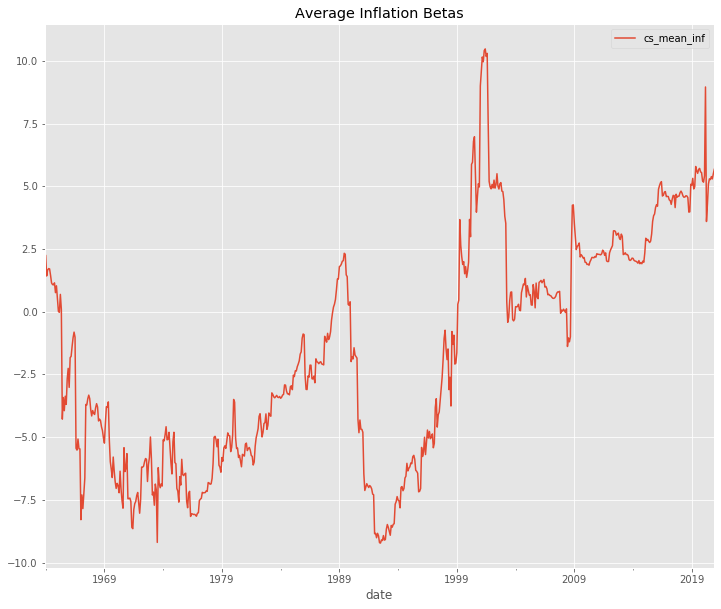

In [815]:
cs_b_stats = crsp_df__.groupby('date')['inf_beta'].\
                apply(lambda x: pd.DataFrame([np.mean(x), np.var(x)], 
                                             index=['cs_mean_inf', 'cs_var_inf']).T).reset_index()
cs_b_stats.drop(columns='level_1', inplace=True)
cs_b_stats.plot(y='cs_mean_inf', x='date')
plt.title('Average Inflation Betas')

In [820]:
crsp_df__ = crsp_df__.merge(cs_b_stats, how='left', on='date')
crsp_df__['inf_beta_weight'] = crsp_df__['var_b']/(crsp_df__['cs_var_inf']+crsp_df__['var_b'])
crsp_df__['inf_beta_va'] = crsp_df__['inf_beta'] + crsp_df__['inf_beta_weight']*\
                                                    (crsp_df__['cs_mean_inf'] - crsp_df__['inf_beta'])

**Calculating Fama French Value weights for each portfolio formation period**

$$w_t = \frac{(1+ret_{t-1})...(1+ret_{t-\tau})ME_{0}}{\sum_{n}(1+ret_{t-1})...(1+ret_{t-\tau})ME_{0}} $$
- $ME_{0}$ is market cap as of end of june
- $(1+ret_{t-\tau})$ is market cap as of end of july

One thing to keep in mind, these weights will only apply if I am rebalancing annually, for monthly rebalancing the value weights will be based on the point in time lagged market capitalization of the stocks

Let's start by tagging the dates first, 


In [834]:
select_month = 1
crsp_df__['year'] = crsp_df__['date_port'].dt.year
crsp_df__['month'] = crsp_df__['date_port'].dt.month
crsp_df__['date_ff'] = crsp_df__['date_port'] + MonthEnd(-select_month)
crsp_df__['year_ff'] = crsp_df__['date_ff'].dt.year
crsp_df__['month_ff'] = crsp_df__['date_ff'].dt.month

- Next we calculate the adjusted market capitalization, that is the numerator of the previous equation
- In the case of IPHL, we will use the lagged market cap as `mcap_adj` instead of the cumulative market cap from portfolio formation period as in fama french, since we are rebalancing every month instead of once a year. Using the FF approach will bias the result since the market cap calculated under that case will keep number of shares outstanding constant starting june every month. But what we need is for both price and quantity to change every month.  

In [835]:
crsp_df__['cum_ret'] = crsp_df__.groupby(['permno', 'year_ff'])['retx'].apply(lambda x: (1+x).cumprod())
crsp_df__['lag_cum_ret'] = crsp_df__.groupby(['permno'])['cum_ret'].shift(1)
crsp_df__['lag_mcap'] = crsp_df__.groupby('permno')['mcap'].shift(1)

crsp_df__['permno_count'] = crsp_df__.groupby('permno').cumcount()
crsp_df__['lag_mcap'].mask(crsp_df__['permno_count'] == 0, 
                           crsp_df__['mcap']/(1+crsp_df__['retx']), 
                           inplace=True)

mcap_base = crsp_df__.loc[crsp_df__['month_ff']==1,['permno', 'year_ff', 'lag_mcap']].\
                rename(columns={'lag_mcap': 'mcap_base'})

crsp_final_df = crsp_df__.merge(mcap_base, how='left', on=['permno', 'year_ff'])
crsp_final_df['mcap_adj'] = crsp_final_df['lag_mcap'].copy()
# np.where(crsp_final_df['month_ff'] == 1, 
#          crsp_final_df['lag_mcap'], 
#          crsp_final_df['mcap_base']*crsp_final_df['lag_cum_ret'])

**Let's also partition out a dataframe for the end of year market capitalization, can be used for variable calculation**

In [841]:
dec_mcap = crsp_final_df.loc[crsp_final_df['month']==12,:].copy()
dec_mcap.rename(columns = {'mcap':'dec_mcap'},inplace=True)
dec_mcap['year'] = dec_mcap['year'] + 1
dec_mcap = dec_mcap.loc[:,['permno','year','dec_mcap']].copy()

**Merge back with monthly returns to get full time series**

So we need the signals to take effect end of every month instead of once a portfolio formation date per year.

In [934]:
crsp_final_df['IP_beta'] = crsp_final_df.groupby('permno')['inf_beta_va'].shift(1)

strat_cols = ['date', 'permno', 'permno_count', 'shrcd', 'exchcd', 'ret_final',
               'mcap','mcap_adj', 'cum_ret', 'year_ff', 'date_port', 'IP_beta']
portmnth_df = crsp_final_df.loc[~crsp_final_df['IP_beta'].isnull(),strat_cols]

**Getting the NYSE Breakpoints**

Conditions for the breakpoints:
- Exchange code 1
- Share code 10 and 11
- positive market cap
- at least 2 years in compustat

In [935]:
nyse_ix = (portmnth_df['mcap'] > 0) & (portmnth_df['exchcd'] == 1) & \
         ((portmnth_df['shrcd'] == 10) | (portmnth_df['shrcd'] == 11)) & (portmnth_df['permno_count'] >= 23)
port_ix = (portmnth_df['mcap'] > 0) & (portmnth_df['permno_count'] >= 23)

ff_meb = (data.DataReader('ME_Breakpoints', 'famafrench', start='1920-10-01')[0].iloc[:,1:]*1000).shift(1).dropna()
ff_meb.index = pd.to_datetime(ff_meb.index.astype(str)) + MonthEnd(0)

nyse_szbucket = pd.DataFrame()
nyse_szbucket['nyse_20'] = ff_meb[(15,20)].reset_index(drop=True).copy()
nyse_szbucket['nyse_50'] = ff_meb[(45,50)].reset_index(drop=True).copy()
nyse_szbucket['date_port'] = ff_meb.index

def szbucket(x):
    if np.isnan(x['mcap_adj']):
        return ''
    elif x['mcap_adj'] <= x['nyse_20']:
        return 'M'
    elif (x['mcap_adj'] > x['nyse_20']) & (x['mcap_adj'] <= x['nyse_50']):
        return 'S'
    else: return 'B'
    
portmnth_df['index'] = portmnth_df.index 
portmnth_df = pd.merge(portmnth_df, nyse_szbucket, how='left', on='date_port')
portmnth_df.index = portmnth_df['index']
portmnth_df.drop(columns='index', inplace=True)
portmnth_df['szbucket'] = np.where(port_ix, portmnth_df.apply(szbucket, axis=1), '')

In [936]:
ip_labels = ['IP' + str(pix) for pix in list(range(1, 11))]
ip_ranks = portmnth_df[port_ix].groupby('date_port')['IP_beta'].apply(pd.qcut, 10, ip_labels).astype(str)
portmnth_df = portmnth_df.merge(ip_ranks, how='left', right_index=True, left_index=True, suffixes=('','_rank'))
portmnth_df.loc[portmnth_df['IP_beta_rank'].isnull(), 'IP_beta_rank'] = ''

portmnth_df['posq_tag'] = np.where(port_ix, 1, 0)
portmnth_df['IP_beta_tag'] = np.where(portmnth_df['IP_beta_rank'] == '', 0, 1)

final_sort = (portmnth_df['mcap_adj'] > 0) & (portmnth_df['IP_beta_tag'] == 1) & (portmnth_df['posq_tag'] == 1) \
                & ((portmnth_df['shrcd'] == 10) | (portmnth_df['shrcd'] == 11))

portmnth_df = portmnth_df[final_sort]

**Calculate the value weighted return**

Simple value weighted return using `mcap_adj`

In [937]:
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

vw_ret_df = portmnth_df.groupby(['date_port', 'szbucket', 'IP_beta_rank']).apply(wavg, 'ret_final', 'mcap_adj').\
                    reset_index().rename(columns={0: 'vw_ret'})
vw_ret_df.head(10)

,date_port,szbucket,IP_beta_rank,vw_ret
0,1965-11-30,B,IP1,0.032803
1,1965-11-30,B,IP10,-0.000495
2,1965-11-30,B,IP2,0.005806
3,1965-11-30,B,IP3,0.021510
4,1965-11-30,B,IP4,0.020291
5,1965-11-30,B,IP5,-0.036786
6,1965-11-30,B,IP6,0.007709
7,1965-11-30,B,IP7,-0.027070
8,1965-11-30,B,IP8,0.017797
9,1965-11-30,B,IP9,0.015386


In [1274]:
vw_ret_df['port_ids'] = vw_ret_df['szbucket'] + vw_ret_df['IP_beta_rank']
IP_factors = vw_ret_df.pivot_table(values='vw_ret',index='date_port', columns='port_ids').reset_index()

sizep_labels = [['M' + ipl, 'S' + ipl , 'B' + ipl] for ipl in ip_labels]
for ix in range(len(sizep_labels)):
    IP_factors[ip_labels[ix]] = IP_factors[sizep_labels[ix]].mean(axis=1)
    
IP_factors['IPHL'] = IP_factors['IP10'] - IP_factors['IP1']
IP_factors['IPLH'] = IP_factors['IP1'] - IP_factors['IP10']

IP_factors.index = IP_factors['date_port']
IP_factors.drop(columns='date_port', inplace=True)
IP_factors.index.name = 'Date'

In [1275]:
rx_labels = ['rx_'+ip_label for ip_label in ip_labels]
IP_factors = IP_factors.merge(ff_factors['RF'].shift(1), how='left', right_index=True, left_index=True)
IP_factors[rx_labels] = IP_factors[ip_labels].sub(IP_factors['RF'], axis=0) 

cpi_surprise_2020 = cpi_surprise[IP_factors.index[-1]].to_frame('cpi_surprise')
cpi_surprise_2020.index.name = 'Date'
IP_factors = IP_factors.merge(cpi_surprise_2020, how='left', right_index=True, left_index=True)

In [1276]:
stats_func = lambda x: pd.Series([np.mean(x)*12, np.std(x)*3.46, np.mean(x)*3.46/np.std(x), 
                                  (np.mean(x)/np.std(x))*np.sqrt(len(x))],
                                 index=['Avg. rx', 'Volatility', 'Sharpe', 't_stat'])
IP_factors[rx_labels[::-1]].apply(stats_func)

,rx_IP10,rx_IP9,rx_IP8,rx_IP7,rx_IP6,rx_IP5,rx_IP4,rx_IP3,rx_IP2,rx_IP1
Avg. rx,0.062452,0.081738,0.086359,0.093192,0.087642,0.093036,0.092855,0.094356,0.091378,0.102030
Volatility,0.236557,0.204602,0.191671,0.184513,0.182590,0.182341,0.185405,0.190584,0.196439,0.216209
Sharpe,0.263379,0.398552,0.449491,0.503872,0.478861,0.509024,0.499636,0.493919,0.464070,0.470786
t_stat,1.958547,2.963726,3.342519,3.746909,3.560920,3.785217,3.715412,3.672899,3.450929,3.500876


In [1255]:
IP_factors['IPLH'].to_clipboard()

Text(0.5, 1.0, 'Inflation Risk - Long Short Portfolio Performance')

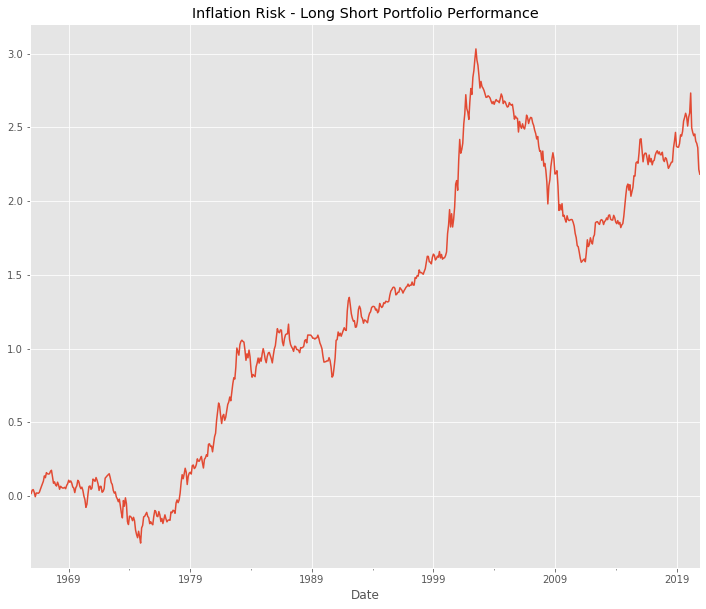

In [1277]:
IP_factors['IPLH'].cumsum().plot()
plt.title('Inflation Risk - Long Short Portfolio Performance')

In [1281]:
IP_factors

,BIP1,BIP10,BIP2,BIP3,BIP4,BIP5,BIP6,BIP7,BIP8,BIP9,...,rx_IP2,rx_IP3,rx_IP4,rx_IP5,rx_IP6,rx_IP7,rx_IP8,rx_IP9,rx_IP10,cpi_surprise
Date,,,,,,,,,,,,,,,,,,,,,
1965-11-30,0.032803,-0.000495,0.005806,0.021510,0.020291,-0.036786,0.007709,-0.027070,0.017797,0.015386,...,0.030987,0.020860,0.035829,0.005034,0.017817,0.008924,0.048729,0.023062,0.018146,0.001491
1965-12-31,0.032364,-0.000844,0.039248,0.005761,0.008506,-0.004317,0.015177,0.014362,0.017191,0.004176,...,0.035861,0.042303,0.025675,0.033984,0.031331,0.028717,0.019743,0.031744,0.036487,0.000437
1966-01-31,0.039733,0.007338,0.008614,0.015157,0.008951,0.024233,-0.002498,0.009324,-0.027865,-0.016502,...,0.060550,0.056188,0.028929,0.039310,0.028592,0.036020,0.029727,0.041931,0.044784,-0.002020
1966-02-28,-0.001267,-0.027459,0.008105,-0.001489,-0.011634,0.003141,-0.000214,-0.035775,-0.018037,-0.020000,...,0.006551,0.015528,-0.002772,0.029444,0.024216,0.002502,-0.005486,0.011506,0.008885,0.004363
1966-03-31,-0.027672,-0.020521,-0.034257,-0.007400,-0.018745,-0.008159,-0.032910,-0.006127,-0.014649,-0.026877,...,-0.034739,-0.026977,-0.013644,-0.026062,-0.023081,-0.013630,-0.029684,-0.022606,-0.010420,-0.001224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.043318,0.115012,0.035446,0.063033,0.054370,0.081912,0.081924,0.164640,0.181694,0.076305,...,0.051330,0.065020,0.051575,0.060530,0.066759,0.103215,0.098868,0.053695,0.097095,-0.000584
2020-09-30,-0.002302,-0.006882,-0.007690,-0.034980,-0.053308,-0.055929,-0.026190,-0.076893,-0.065601,-0.020683,...,-0.030215,-0.037573,-0.049752,-0.048966,-0.029796,-0.050745,-0.051772,-0.028301,-0.024843,-0.001019
2020-10-31,-0.033202,-0.008751,-0.029052,-0.020105,-0.030827,-0.014356,-0.015298,-0.036514,-0.031866,0.038884,...,0.005629,0.022253,0.014814,0.022442,0.018951,-0.001904,0.015005,0.034759,0.026070,-0.001597


In [1283]:
IP_factors.loc[:'2014/12',rx_labels[::-1]]

,rx_IP10,rx_IP9,rx_IP8,rx_IP7,rx_IP6,rx_IP5,rx_IP4,rx_IP3,rx_IP2,rx_IP1
Date,,,,,,,,,,
1965-11-30,0.018146,0.023062,0.048729,0.008924,0.017817,0.005034,0.035829,0.020860,0.030987,0.031118
1965-12-31,0.036487,0.031744,0.019743,0.028717,0.031331,0.033984,0.025675,0.042303,0.035861,0.042070
1966-01-31,0.044784,0.041931,0.029727,0.036020,0.028592,0.039310,0.028929,0.056188,0.060550,0.067323
1966-02-28,0.008885,0.011506,-0.005486,0.002502,0.024216,0.029444,-0.002772,0.015528,0.006551,0.012567
1966-03-31,-0.010420,-0.022606,-0.029684,-0.013630,-0.023081,-0.026062,-0.013644,-0.026977,-0.034739,-0.029120
...,...,...,...,...,...,...,...,...,...,...
2014-08-31,0.033641,0.044762,0.049562,0.046598,0.038968,0.058773,0.041143,0.043383,0.048514,0.042261
2014-09-30,-0.081173,-0.081144,-0.054521,-0.052664,-0.051668,-0.046675,-0.039595,-0.034428,-0.027659,-0.030401
2014-10-31,-0.004300,0.024599,0.041411,0.050904,0.038747,0.039865,0.058718,0.060107,0.059440,0.068222


In [1284]:
beta_func = lambda x: sm.OLS(x, sm.add_constant(IP_factors.loc[:'2014/12','cpi_surprise']),
                             missing='drop').fit().params[1]

IP_factors.loc[:'2014/12',rx_labels[::-1]].apply(beta_func).to_frame('Ex-post inflation_betas').T

,rx_IP10,rx_IP9,rx_IP8,rx_IP7,rx_IP6,rx_IP5,rx_IP4,rx_IP3,rx_IP2,rx_IP1
Ex-post inflation_betas,0.023165,-0.726516,-1.39355,-1.729956,-2.041365,-2.070434,-2.217994,-2.771746,-2.766618,-3.216173


In [1279]:
IP_factors[['IPHL','IPLH']].apply(beta_func).to_frame('Ex-post inflation_betas').T

,IPHL,IPLH
Ex-post inflation_betas,3.112359,-3.112359


In [1256]:
reg_data['IPLH', '']

,MKT_RF,SMB,HML,RMW,CMA,RF,MOM,US10Y_RF,QMJ,IPLH
1990-02-28,0.0111,0.0119,0.0065,-0.0020,-0.0064,0.0057,-0.0053,-0.004015,-0.007896,0.001770
1990-03-31,0.0183,0.0166,-0.0303,0.0218,-0.0103,0.0064,0.0164,-0.007915,0.019582,0.002174
1990-04-30,-0.0336,-0.0039,-0.0247,0.0172,-0.0097,0.0069,0.0243,-0.024764,0.027591,0.005142
1990-05-31,0.0842,-0.0239,-0.0389,0.0163,-0.0157,0.0068,0.0305,0.030310,0.000917,-0.001644
1990-06-30,-0.0109,0.0137,-0.0199,-0.0105,-0.0034,0.0063,0.0243,0.011800,0.015849,0.023125
...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.0763,-0.0094,-0.0294,0.0427,-0.0144,0.0001,0.0051,-0.015241,0.004750,-0.048819
2020-09-30,-0.0363,0.0007,-0.0251,-0.0115,-0.0177,0.0001,0.0305,0.003277,0.001698,-0.014921
2020-10-31,-0.0210,0.0476,0.0403,-0.0060,-0.0053,0.0001,-0.0303,-0.016922,0.009534,-0.029568
2020-11-30,0.1247,0.0675,0.0211,-0.0278,0.0105,0.0001,-0.1225,0.004333,-0.092194,-0.147074


In [1259]:
reg_data

,MKT_RF,SMB,HML,RMW,CMA,RF,MOM,US10Y_RF,QMJ,IPLH,SMU
1996-07-31,-0.0597,-0.0382,0.0516,0.0295,0.0259,0.0045,-0.0011,-0.003484,0.023513,-0.017921,-0.030254
1996-08-31,0.0277,0.0258,-0.0078,-0.0041,-0.0242,0.0041,-0.0005,-0.010411,-0.003232,0.015785,0.021122
1996-09-30,0.0501,-0.0137,-0.0276,0.0124,-0.0218,0.0044,0.0270,0.019336,0.019962,0.011061,0.016380
1996-10-31,0.0086,-0.0384,0.0492,0.0152,0.0297,0.0042,0.0391,0.027161,0.010472,0.012731,-0.011810
1996-11-30,0.0625,-0.0382,0.0146,0.0205,-0.0073,0.0041,-0.0223,0.024204,0.016812,0.006203,-0.001987
...,...,...,...,...,...,...,...,...,...,...,...
2020-02-29,-0.0813,-0.0003,-0.0392,-0.0161,-0.0249,0.0012,-0.0023,0.035527,-0.014900,0.028480,0.025145
2020-03-31,-0.1338,-0.0838,-0.1396,-0.0138,0.0121,0.0012,0.0855,0.040224,0.070648,0.135766,0.046639
2020-04-30,0.1365,0.0279,-0.0139,0.0251,-0.0103,0.0000,-0.0549,0.004947,-0.028016,-0.236053,0.014102
2020-05-31,0.0558,0.0193,-0.0505,0.0071,-0.0328,0.0001,0.0067,-0.000391,-0.027759,-0.030801,0.058030


In [1258]:
factors = pd.concat([ff_factors, mom_factor, extra_df], axis=1)
factors.rename(columns={'Mkt-RF': 'MKT_RF', 'US10Y':'US10Y_RF'}, inplace=True)
factors['US10Y_RF'] = factors['US10Y_RF'].sub(factors['RF'].shift(1), axis=0)
reg_data = pd.concat([factors, IP_factors['IPLH'], stab_data['SMU']], axis=1).dropna()
reg_data['IPSMU'] = reg_data[['IPLH','SMU']].average(axis=1)


fut_df = pd.read_excel('futures_data.xlsx', index_col=0).pct_change(1).dropna()
mkt_rf = data.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', '1920-01-01')[0][['Mkt-RF']]/100
mkt_rf.columns = ['MKT_RF']
eq_shock_df = pd.concat([mkt_rf['MKT_RF'], fut_df['US1 Comdty']], axis=1).dropna()

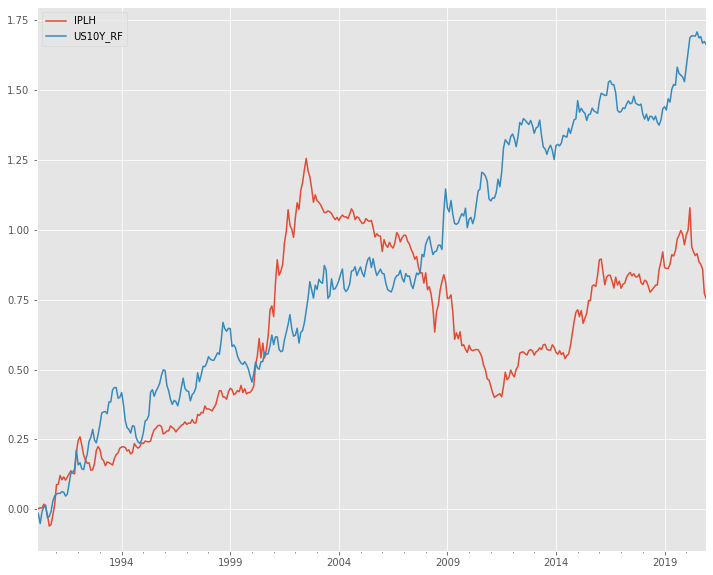

In [1063]:
reg_data[['IPLH','US10Y_RF']].apply(lambda x: x*(0.10/(np.std(x)*3.46))).cumsum().plot()

In [1257]:
stab_data

,Stable,Unstable,Stab40,Stab60,Stab80,SMU
date,,,,,,
1996-07-31,-0.063672,-0.033418,-0.058554,-0.046572,-0.040262,-0.030254
1996-08-31,0.032244,0.011121,0.029069,0.041459,0.035446,0.021122
1996-09-30,0.067043,0.050663,0.068505,0.049609,0.054907,0.016380
1996-10-31,0.017430,0.029241,0.001936,0.025644,0.016900,-0.011810
1996-11-30,0.067135,0.069122,0.077895,0.062363,0.089532,-0.001987
...,...,...,...,...,...,...
2020-02-29,-0.061903,-0.087049,-0.065921,-0.050681,-0.047279,0.025145
2020-03-31,-0.118369,-0.165009,-0.156342,-0.129855,-0.037943,0.046639
2020-04-30,0.153083,0.138981,0.119395,0.114097,0.115968,0.014102


In [1273]:
models = ['IPSMU ~ MKT_RF', 'IPSMU ~ US10Y_RF', 'IPSMU ~ MKT_RF + US10Y_RF', 
          'IPSMU ~ MKT_RF + SMB + HML + RMW + CMA + MOM + QMJ']
orders = ['Intercept', 'MKT_RF', 'US10Y_RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'QMJ']

model_list = []

for model in models:
    model_list.append(smf.ols(model, reg_data).fit())
output = summary_col(model_list,
                     stars = True, 
                     regressor_order = orders)
output

,IPSMU I,IPSMU II,IPSMU III,IPSMU IIII
Intercept,0.0050***,0.0023,0.0040**,0.0017
,(0.0016),(0.0017),(0.0016),(0.0016)
MKT_RF,-0.2383***,,-0.2041***,-0.0498
,(0.0345),,(0.0353),(0.0451)
US10Y_RF,,0.3869***,0.2616***,
,,(0.0774),(0.0765),
SMB,,,,0.0303
,,,,(0.0549)
HML,,,,0.1282*
,,,,(0.0697)


In [1268]:
models = ['SMU ~ MKT_RF', 'SMU ~ US10Y_RF', 'SMU ~ MKT_RF + US10Y_RF', 
          'SMU ~ MKT_RF + SMB + HML + RMW + CMA + MOM + QMJ']
orders = ['Intercept', 'MKT_RF', 'US10Y_RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'QMJ']

model_list = []

for model in models:
    model_list.append(smf.ols(model, reg_data).fit())
output = summary_col(model_list,
                     stars = True, regressor_order = orders)
output

,SMU I,SMU II,SMU III,SMU IIII
Intercept,0.0031**,0.0030**,0.0025,0.0034**
,(0.0015),(0.0015),(0.0015),(0.0014)
MKT_RF,0.0477,,0.0677**,-0.0085
,(0.0323),,(0.0335),(0.0408)
US10Y_RF,,0.1119,0.1535**,
,,(0.0700),(0.0726),
SMB,,,,0.2095***
,,,,(0.0497)
HML,,,,-0.1466**
,,,,(0.0630)


In [250]:
def cum_residuals(df, x='US1 Comdty', y='MKT_RF'):
    
    return sm.OLS(df[y], 
                  sm.add_constant(df[x]),
                  missing='drop').fit().resid.to_frame()\
                    .apply(lambda x: np.std(x))*np.sqrt(252)

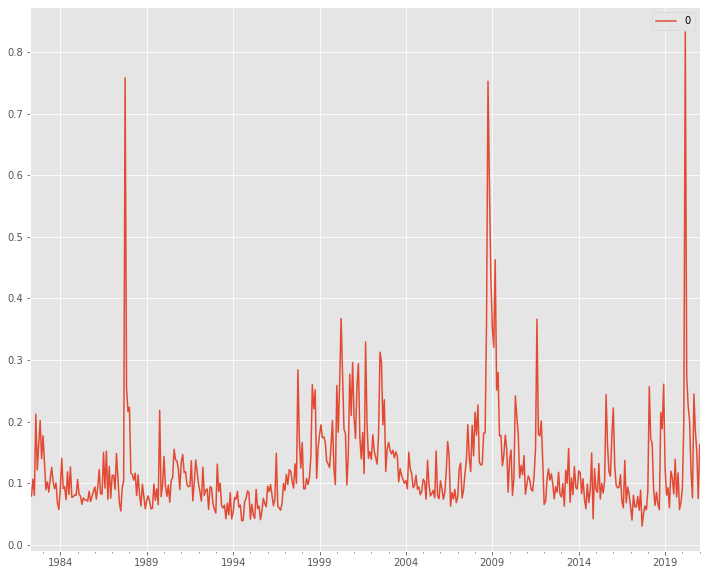

In [251]:
eq_shock_df.groupby(pd.Grouper(freq='M'))[['MKT_RF','US1 Comdty']].apply(cum_residuals).plot()

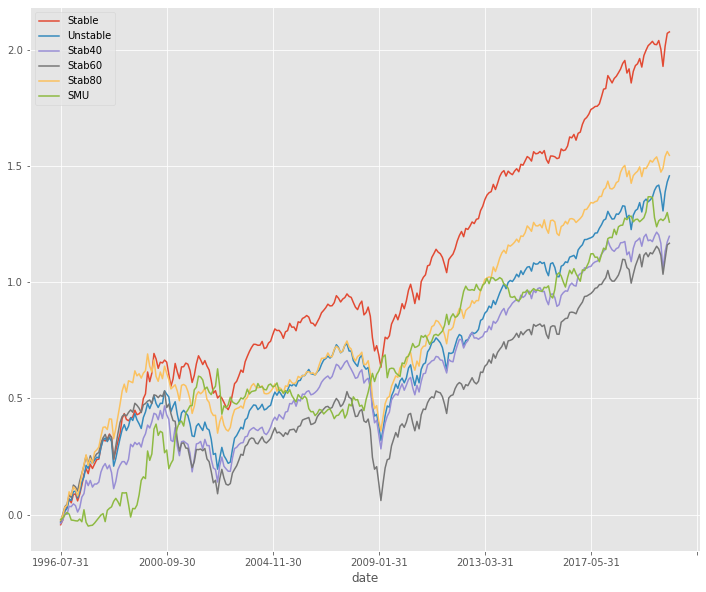

In [45]:
stab_data.apply(lambda x: x*(0.10/(x.std()*3.46))).cumsum().plot()